In [33]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import transbigdata as tbd
import warnings
from keras.utils import plot_model
import pydot
import os, random
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [34]:
def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['trajectory_id']):
        data_temp = data.loc[data['trajectory_id'] == traj_id]
        # 重置索引，让切片的索引从0开始
        data_temp = data_temp.reset_index(drop=True)
        first_lon = data_temp.loc[0, 'lon']
        first_lat = data_temp.loc[0, 'lat']
        end_lon = data_temp.loc[data_temp.shape[0] - 1, 'lon']
        end_lat = data_temp.loc[data_temp.shape[0] - 1, 'lat']

        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [35]:
def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
    # model.add(Dropout(0.3))
    model.add(Dense(train_Y.shape[1]))
    model.add(Activation("relu"))
    adam = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    
    # # 绘制模型结构图
    # plot_model(model, to_file='./model.png', show_shapes=True)

    # 回调函数
    log = CSVLogger(f"./log.csv", separator=",", append=True)
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
                               mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)

    # 适时停止训练
    earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    model.fit(train_X, train_Y, epochs=20, batch_size=64, verbose=1, validation_split=0.1,
                  callbacks=[log, reduce, earlystop])
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    # 保存模型
    model.save(f"./model.h5")
    # 打印神经网络结构，统计参数数目
    model.summary()
    return model

In [36]:
# 重采样
def resample_data(df):
    data_resampled = pd.DataFrame()
    for i in set(df['trajectory_id']):
        data_temp = df.loc[df['trajectory_id'] == i]
        data_temp = data_temp.loc[:, ['time', 'mmsi', 'lon', 'lat', 'sog', 'cog', 'trajectory_id']]
        # 时间转化为datetime类型
        data_temp['time'] = pd.to_datetime(data_temp['time'])
        # 设置时间为索引
        data_temp.set_index('time', inplace=True)
        # 移除重复索引
        data_temp = data_temp[~data_temp.index.duplicated(keep='first')]
        # data_temp = df.resample('30S').mean()
        # data_temp = df.resample('30S').ffill()   # 采样间隔降低（采样频率升高）时会出现缺失数据，ffill()向前填充缺失值，使用前面的值来填充缺失的值， bfill()向后填充缺失值
        data_temp = data_temp.resample('30S').mean().interpolate(method='linear')  # 使用interpolate()函数对缺失值进行插值，linear:线性插值
        # 采用插值补充缺失值时MMSI数据变为float类型，将MMSI类型转换为整型
        data_temp.loc[:, 'mmsi'] = data_temp.loc[:, 'mmsi'].astype('int')
        data_resampled = pd.concat([data_resampled, data_temp])
    return data_resampled

In [37]:
# 获取数据
train = pd.read_csv("./data/train.csv", index_col=0)
test = pd.read_csv("./data/test.csv", index_col=0)
train = resample_data(train)
test = resample_data(test)
train.head()


,mmsi,lon,lat,sog,cog,trajectory_id
time,,,,,,
2024-04-21 19:47:00,413841262,106.580583,29.603233,104.0,285.0,6144.0
2024-04-21 19:47:30,413841262,106.581404,29.604516,104.5,295.0,6144.0
2024-04-21 19:48:00,413841262,106.582224,29.605798,105.0,305.0,6144.0
2024-04-21 19:48:30,413841262,106.583045,29.607081,105.5,315.0,6144.0
2024-04-21 19:49:00,413841262,106.583865,29.608363,106.0,325.0,6144.0


In [38]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
print(maxmin)
# 步长
print(set(train['mmsi']))  # set()函数创建一个不包含重复元素的集合
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)
print(train_seq.shape)

[array([ 106.73706833,   29.62286333, 1022.        , 3600.        ]), array([106.57676833,  29.56485   ,   6.        ,   0.        ])]
{413880322, 413825029, 413849607, 413872136, 413872137, 413837328, 413847572, 413818905, 413868057, 413876254, 413827104, 413827106, 413827111, 413859879, 413849642, 413827117, 413782062, 413771827, 413831222, 413782072, 413880382, 413788225, 413835345, 413773906, 413773907, 413847644, 413812832, 413839456, 413798506, 413872238, 413870198, 413870199, 413786241, 413837452, 413773967, 413837458, 413780121, 413829279, 413780131, 413880486, 413780137, 413872301, 413780141, 413780143, 413827252, 413825207, 413847741, 413995198, 413835457, 413823172, 413880526, 413823187, 413958371, 413868264, 413772009, 413868265, 413868266, 413872386, 413872397, 413864206, 413866257, 413849874, 413866258, 413849876, 413770006, 413956381, 413829414, 413823277, 413868334, 413794607, 413765939, 413798717, 413798718, 413000000, 413839695, 413870418, 413874514, 413874515, 413874

In [29]:
# 删除log.csv
if os.path.exists("./log.csv"):
    os.remove("./log.csv")

# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)


Train on 124501 samples, validate on 13834 samples
Epoch 1/20
124501/124501 [==============================] - 66s 529us/step - loss: 0.0017 - acc: 0.9661 - val_loss: 1.6747e-04 - val_acc: 0.9902
Epoch 2/20
124501/124501 [==============================] - 66s 530us/step - loss: 5.7337e-04 - acc: 0.9802 - val_loss: 2.1832e-04 - val_acc: 0.9881

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 3/20
124501/124501 [==============================] - 67s 537us/step - loss: 5.0879e-04 - acc: 0.9818 - val_loss: 1.3604e-04 - val_acc: 0.9894

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/20
124501/124501 [==============================] - 67s 537us/step - loss: 4.6856e-04 - acc: 0.9836 - val_loss: 1.1911e-04 - val_acc: 0.9917
Epoch 5/20
124501/124501 [==============================] - 68s 549us/step - loss: 4.6349e-04 - acc: 0.9837 - val_loss: 1.1983e-04 - val_acc: 0.9918

Epoch 00005: ReduceLROnPlateau reducing learni

In [9]:
# 加载模型
model = load_model("./model.h5", compile = False)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 268,292
Trainable params: 268,292
Non-trainable params: 0
_________________________________________________________________


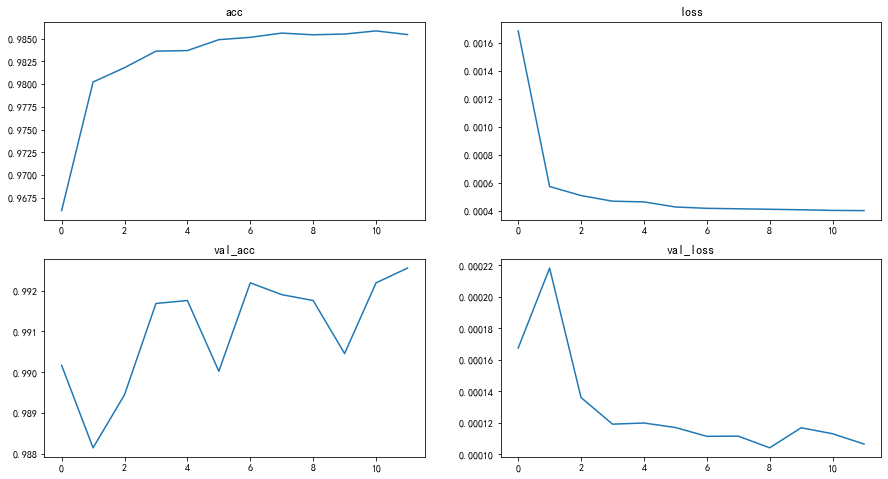

In [31]:
logs = pd.read_csv("./log.csv")

fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0][0].plot(logs['epoch'],logs['acc'], label='acc')
ax[0][0].set_title('acc')

ax[0][1].plot(logs['epoch'],logs['loss'], label='loss')
ax[0][1].set_title('loss')

ax[1][0].plot(logs['epoch'],logs['val_acc'], label='val_acc')
ax[1][0].set_title('val_acc')

ax[1][1].plot(logs['epoch'],logs['val_loss'], label='val_loss')
ax[1][1].set_title('val_loss')

plt.show()

trajectory_id=2220.0
最大值: 0.20224161687331468
最小值: 0.003252954051847469
均值: 0.06455116714446239
方差: 0.002465424501753033
标准差: 0.04965304121353528
中位数: 0.04873477616457239


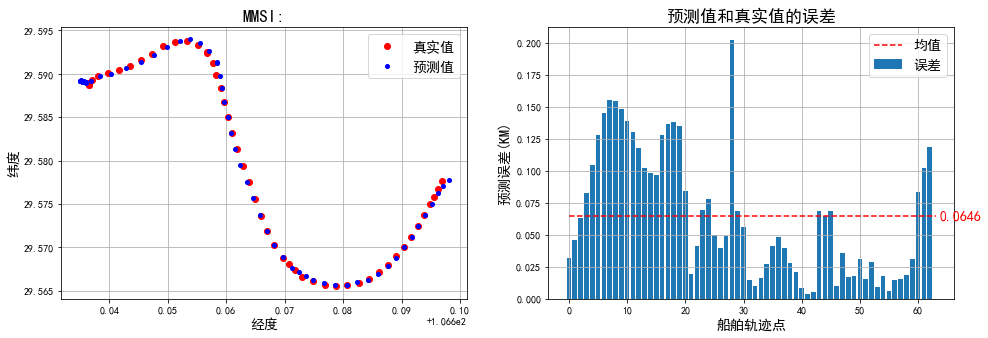

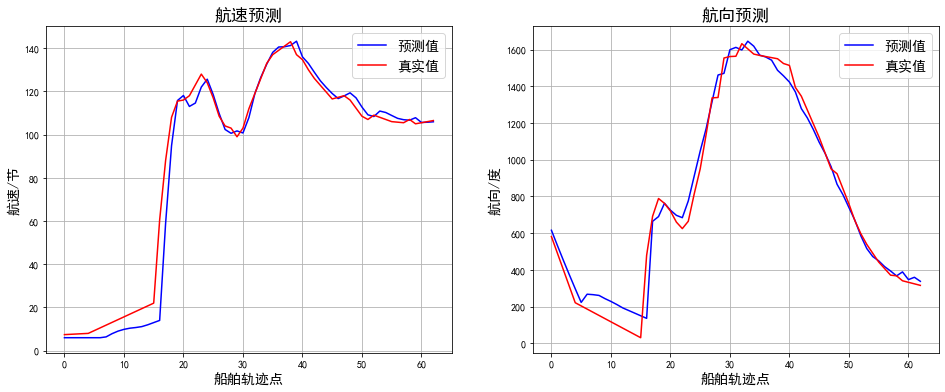

In [10]:
test = pd.read_csv("./data/test.csv",index_col=0)
test = resample_data(test)
test_points_ids = list(set(test['trajectory_id']))

for ids in test_points_ids[172:173]:
    print(f'trajectory_id={ids}')
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test['trajectory_id'] == ids], windows, maxmin)
    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')

    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    # 画测试样本数据库
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
    bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
    # tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    # plt.xlim((106.60, 106.74))
    # plt.ylim((29.56, 29.63))
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()

trajectory_id=2189.0


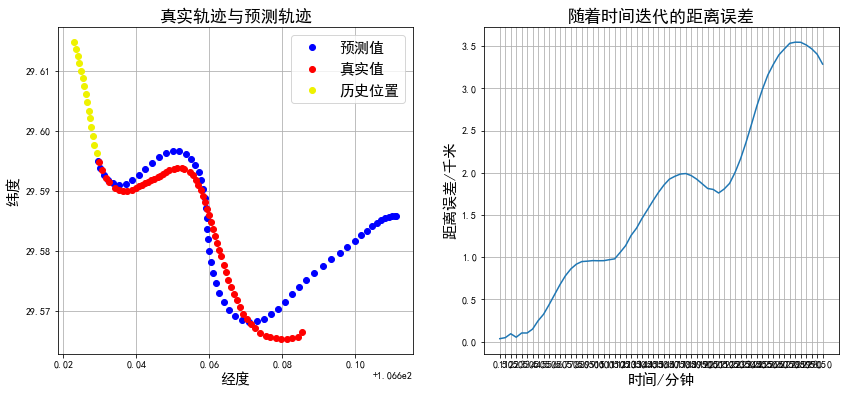

In [30]:
# 多步预测，船舶位置在最后一个黄色点位置
test_points_ids = list(set(test['trajectory_id']))
# for ids in test_points_ids[27:28]: # test_points_ids[27:28],[27:28],[9，10],[39,40],[2018,2019]
for ids in random.sample(test_points_ids, 1):   # 随机选取一条轨迹进行预测，random.sample(test_points_ids, 1)    不可以：2161，可以的：2011,2036
    print(f'trajectory_id={ids}')
    test_seq, test_label = createSequence(test.loc[test['trajectory_id'] == ids], windows,maxmin)

    y_pre = []
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 得到真实值
    _,true_lables = FNormalizeMult(y_pre,np.copy(test_label),maxmin)

    for start_id in range(15,16):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 预测点的数量
        maxStep = min(60,test_seq.shape[0] - start_id)
        # 循环预测
        for i in range(maxStep):
            y_hat = model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
        bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
        # tbd.plot_map(plt,bounds,zoom = 16,style = 3)
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
        plt.title(f'真实轨迹与预测轨迹',fontsize=17)
        plt.xlabel("经度",fontsize=15)
        plt.ylabel("纬度",fontsize=15)
        # plt.xlim((106.56, 106.76))
        # plt.ylim((29.56, 29.63))
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(0.5,0.5*(maxStep)+0.5,0.5),f_y_pre[:,4])
        plt.xticks(np.arange(0.5,0.5*(maxStep)+0.5,0.5))
        plt.title(f'随着时间迭代的距离误差',fontsize=17)
        plt.xlabel("时间/分钟",fontsize=15)
        plt.ylabel("距离误差/千米",fontsize=15)
        plt.grid()